In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2682655455280408568
]


In [3]:
import os
import math
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
targets = pd.read_csv('D:/3D-CNN/D/jester-v1-train.csv', index_col=0, squeeze=True, header=None,sep = ";").to_dict()

targets_validation = pd.read_csv('D:/3D-CNN/D/jester-v1-validation.csv' ,index_col=0, squeeze=True, header=None,sep = ";").to_dict()

In [6]:
len(targets)

118562

In [7]:
targets_name = [
    'Doing other things',
    'Swiping Right',
    'Swiping Left',
    'Zooming In With Two Fingers',
    'Zooming Out With Two Fingers',
    'Stop Sign',
    'No gesture'
]

In [8]:
path = "D:/3D-CNN/D/final_train_set/"
path_cv = "D:/3D-CNN/D/final_valid_set/"

dirs = os.listdir(path)
dirs_cv = os.listdir(path_cv)

In [9]:
print(len(dirs))
print(len(dirs_cv))

11500
3601


In [10]:
training_count = 10

In [11]:
hm_frames = 32 
def get_unify_frames(path):
    offset = 0
    frames = os.listdir(path)
    frames_count = len(frames)
    if hm_frames > frames_count:
        frames += [frames[-1]] * (hm_frames - frames_count)
    elif hm_frames < frames_count:
        frames = frames[0:hm_frames]
    return frames  

In [12]:
def resize_frame(frame):
    frame = img.imread(frame)
    frame = cv2.resize(frame, (64, 64))
    return frame
    

In [13]:
%%time
counter_training = 0 
training_targets = []
new_frames = [] 
for directory in dirs:
    new_frame = []
    
    frames = get_unify_frames(path+directory)
    if len(frames) == hm_frames: 
        for frame in frames:
            frame = resize_frame(path+directory+'/'+frame)
            new_frame.append(rgb2gray(frame))
            if len(new_frame) == 15: 
                new_frames.append(new_frame) 
                training_targets.append(targets_name.index(targets[int(directory)]))
                counter_training +=1
                new_frame = []

Wall time: 53min 57s


In [14]:
%%time
counter_validation = 0
cv_targets = []
new_frames_cv = []
for directory in dirs_cv:
    new_frame = []
   
    frames = get_unify_frames(path_cv+directory)
    if len(frames)==hm_frames:
        for frame in frames:
            frame = resize_frame(path_cv+directory+'/'+frame)
            new_frame.append(rgb2gray(frame))
            if len(new_frame) == 15:
                new_frames_cv.append(new_frame)
                cv_targets.append(targets_name.index(targets_validation[int(directory)]))
                counter_validation +=1
                new_frame = []

Wall time: 25min 59s


In [15]:
print(len(new_frames))
print(len(training_targets))

23000
23000


In [16]:
print(len(new_frames_cv))
print(len(cv_targets))

7202
7202


In [17]:
type(cv_targets)

list

In [17]:
training_targets[0:20]

[1, 1, 5, 5, 6, 6, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 4, 4]

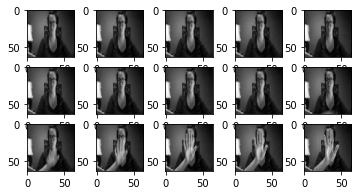

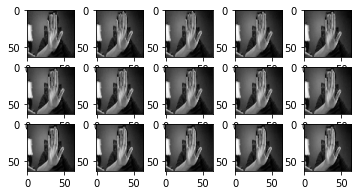

<Figure size 432x288 with 0 Axes>

In [18]:
fig = plt.figure()
for i in range(2,4):
    for num,frame in enumerate(new_frames[i][0:18]):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(frame, cmap='gray')
    fig = plt.figure()
plt.show()

In [19]:
%%time
training_data = np.array(new_frames[0:counter_training], dtype=np.float32)

Wall time: 9min 49s


In [20]:
def release_list(a):
    del a[:]
    del a

In [21]:
%%time
release_list(new_frames)

Wall time: 8min 45s


In [22]:
%%time
cv_data = np.array(new_frames_cv[0:counter_validation], dtype=np.float32)

Wall time: 1min 19s
Compiler : 552 ms
Parser   : 805 ms


In [23]:
%%time
release_list(new_frames_cv)

Wall time: 59.2 s


In [24]:
training_data.shape

(23000, 15, 64, 64)

In [25]:
cv_data.shape

(7202, 15, 64, 64)

In [26]:
%%time
print('old mean', training_data.mean())

old mean 109.11762
Wall time: 9.17 s


In [27]:
%%time
scaler = StandardScaler()
scaled_images  = scaler.fit_transform(training_data.reshape(-1, 15*64*64))
print('new mean', scaled_images.mean())

new mean 1.2156843e-08
Wall time: 1min 53s
Parser   : 280 ms


In [28]:
%%time
scaled_images  = scaled_images.reshape(-1, 15, 64, 64, 1)
print(scaled_images.shape)

(23000, 15, 64, 64, 1)
Wall time: 0 ns


In [29]:
%%time
print('old mean', cv_data.mean())

old mean 107.752235
Wall time: 1min 41s


In [30]:
%%time
scaler = StandardScaler()
scaled_images_cv  = scaler.fit_transform(cv_data.reshape(-1, 15*64*64))
print('new mean',scaled_images_cv.mean())

new mean 9.790931e-09
Wall time: 27.8 s


In [31]:
%%time
scaled_images_cv  = scaled_images_cv.reshape(-1, 15, 64, 64, 1)
print(scaled_images_cv.shape)

(7202, 15, 64, 64, 1)
Wall time: 0 ns


In [42]:
# My model
class Conv3DModel(tf.keras.Model):
    def __init__(self):
        super(Conv3DModel, self).__init__()
        self.conv1 = tf.compat.v2.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
        self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
        self.conv2 = tf.compat.v2.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
        self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2,2), data_format='channels_last')
   
    # LSTM & Flatten
        self.convLSTM =tf.keras.layers.ConvLSTM2D(40, (3, 3))
        self.flatten =  tf.keras.layers.Flatten(name="flatten")

    # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(7, activation='softmax', name="output")
    

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.convLSTM(x)
    #x = self.pool2(x)
    #x = self.conv3(x)
    #x = self.pool3(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.out(x)

In [43]:
model = Conv3DModel()

In [44]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
x_train = np.array(scaled_images)
y_train = np.array(training_targets)
x_val = np.array(scaled_images_cv)
y_val = np.array(cv_targets)

In [35]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(23000, 15, 64, 64, 1)
(23000,)
(7202, 15, 64, 64, 1)
(7202,)


In [45]:
checkpoint_path = "train_todays/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [46]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [ ]:
history = model.fit(x_train, y_train,
                    callbacks = [cp_callback],
                    validation_data=(x_val, y_val),
                    batch_size=32,
                    epochs=10)

In [48]:
history.history

{'loss': [1.3415336608886719,
  0.9766994714736938,
  0.8025403618812561,
  0.6502112150192261,
  0.5043352842330933,
  0.35424351692199707,
  0.22955742478370667,
  0.13747690618038177,
  0.10485037416219711,
  0.08542665839195251],
 'accuracy': [0.4903913140296936,
  0.6556521654129028,
  0.723130464553833,
  0.7795652151107788,
  0.8262608647346497,
  0.8829130530357361,
  0.9243913292884827,
  0.9566521644592285,
  0.9683912992477417,
  0.9720434546470642],
 'val_loss': [1.1160802841186523,
  0.9466859102249146,
  0.8671624064445496,
  0.8721331357955933,
  0.9298349618911743,
  1.0578817129135132,
  1.1661666631698608,
  1.4003756046295166,
  1.55642569065094,
  1.604585886001587],
 'val_accuracy': [0.6024715304374695,
  0.685226321220398,
  0.7166064977645874,
  0.7254928946495056,
  0.722854733467102,
  0.7207720279693604,
  0.7088308930397034,
  0.7029991745948792,
  0.7089697122573853,
  0.7043876647949219]}

In [49]:
model.save_weights('D:/3D-CNN/D/FinalModel/3D-CNN_LSTM_weights', save_format='tf')

In [50]:
# USING ADV CODE:

In [32]:
class Conv3DModel(tf.keras.Model):
    def __init__(self):
        super(Conv3DModel, self).__init__()
        self.conv1 = tf.compat.v2.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
        self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
        self.conv2 = tf.compat.v2.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
        self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2,2), data_format='channels_last')
   
    # LSTM & Flatten
        self.convLSTM =tf.keras.layers.ConvLSTM2D(40, (3, 3))
        self.flatten =  tf.keras.layers.Flatten(name="flatten")

    # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(7, activation='softmax', name="output")
    

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.convLSTM(x)
    #x = self.pool2(x)
    #x = self.conv3(x)
    #x = self.pool3(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.out(x)

In [33]:
model = Conv3DModel()

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, training_targets))
cv_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_cv, cv_targets))

In [35]:
model(scaled_images[0:2])

<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[0.15522437, 0.13266416, 0.13334297, 0.14805256, 0.12308123,
        0.15356319, 0.15407152],
       [0.1556905 , 0.1305005 , 0.132331  , 0.15028338, 0.119919  ,
        0.15529129, 0.1559843 ]], dtype=float32)>

In [36]:
model.summary()

Model: "conv3d_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               multiple                  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) multiple                  0         
_________________________________________________________________
conv1 (Conv3D)               multiple                  55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    multiple                  149920    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
d1 (Dense)                   multiple                 

In [38]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [39]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [40]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_fn(targets, predictions)
    # Compute the gradient which respect to the loss
    grads = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

In [41]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_fn(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

In [42]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, 'last_new_today/all_fk_ckpts', max_to_keep=10)
ckpt.restore(manager.latest_checkpoint)

In [ ]:
epoch = 10
batch_size = 32
b = 0
training_acc = []
validation_acc = []

for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(training_targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size

    # Validation set
    for images_batch, targets_batch in cv_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)
        template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
        print(template.format(
            epoch+1,
            valid_loss.result(), 
            valid_accuracy.result()*100)
    )

    training_acc.append(float(train_accuracy.result()*100))
    validation_acc.append(float(valid_accuracy.result()*100))
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

print(manager.checkpoints)

In [44]:
model.save_weights('D:/3D-CNN/D/All_Models/3D-CNN_LSTM_Adv_weights', save_format='tf')

In [58]:
print(manager.checkpoints)

['last_new_today/all_fk_ckpts\\ckpt-1', 'last_new_today/all_fk_ckpts\\ckpt-2', 'last_new_today/all_fk_ckpts\\ckpt-3', 'last_new_today/all_fk_ckpts\\ckpt-4', 'last_new_today/all_fk_ckpts\\ckpt-5', 'last_new_today/all_fk_ckpts\\ckpt-6', 'last_new_today/all_fk_ckpts\\ckpt-7', 'last_new_today/all_fk_ckpts\\ckpt-8', 'last_new_today/all_fk_ckpts\\ckpt-9', 'last_new_today/all_fk_ckpts\\ckpt-10']


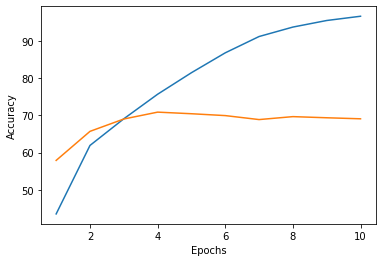

In [48]:
plt.plot([1,2,3,4,5,6,7,8,9,10],training_acc, '-' )
plt.plot([1,2,3,4,5,6,7,8,9,10],validation_acc, '-' )

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()